Import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [ ]:
# Added to be able to run in Google Colab. Run this cell if running the notebook in a hosted runtime. Don't run for a local runtime.

from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')    # Set this to the directory where you have saved the "utils" directory of Python scripts.
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')       # Set this to the directory where you have saved the "utils" directory of Python scripts.

import utils

In [ ]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.draw import rectangle_perimeter,circle_perimeter, disk
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
2.0.0+cu118


# Define functions

In [ ]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

In [ ]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
# Non-Max Suppression
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt


# Data and models

In [ ]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'Finetuning_allSlides'
trial = 'Trial_01' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # Balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # For regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [1024,1024]       # set to crop size, to tell model what size tensor to expect
total_epoch_num = 30      # total number of epoch in training
base_lr =0.0005           # base learning rate
scaleList = [0]           # the number of output layer for U-net

exp_dir = '/content/gdrive/MyDrive/ENSO_project/02_det/exp' # experiment directory
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial)  # Location to read trained models.

cuda:0


In [ ]:
eval_dir = '/content/gdrive/MyDrive/ENSO_project/02_det/eval' 
eval_dir = os.path.join(eval_dir, project_name, trial) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

In [ ]:
path_to_image = '/content/gdrive/MyDrive/ENSO_project/01_data/02_tiles'
path_to_mask = '/content/gdrive/MyDrive/ENSO_project/01_data/04_masks'
path_to_annot= '/content/gdrive/MyDrive/ENSO_project/01_data/03_annot'   ### format of annot: [[label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r]]
with open(os.path.join(save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 1226, 306)

In [ ]:
################## best model ###################
path_to_save_paramOnly = path.join(exp_dir, trial, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

False


In [ ]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image=path_to_image,
                 path_to_annot=path_to_annot,
                 path_to_mask=path_to_mask,
                 dbinfo=dbinfo,
                 size=newSize, 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx]

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[1])
        current_distTransform_path=os.path.join(self.path_to_mask, current_example[0], current_example[1])
        curPickleName = os.path.join(self.path_to_annot, current_example[0])

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice).astype(np.float32)/255)
        image = np.block(imagestack_array)
        # image = image.astype(np.float32)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0.0)

        for file in sorted(os.listdir(current_distTransform_path)):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.expand_dims(mask, axis=2)  
            mask = mask.astype(np.float32)   

        for file in os.listdir(curPickleName):
          if file.endswith(os.path.join(current_example[1]+'.pkl')):
            with open(os.path.join(curPickleName, file), 'rb') as handle:
              annot = pickle.load(handle)

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0.0] = 1.0          # 11/30/21 added   
        label = label.astype(np.float32)  # factor=size[0]/1000

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added
        image_label = image_label.astype(np.float32)


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)       
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        crop0 = image_label[0:800, 0:800,:]
        crop1 = image_label[0:800, width-800:,:]
        crop2 = image_label[height-800:, 0:800,:]
        crop3 = image_label[height-800:, width-800:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = image.type(torch.float)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example


In [ ]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              # path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=False, 
                         num_workers=4) # num_work can be set to batch_size

# Step-by-step visualization of evaluation
------------------------------------------
To batch export .txt files of detections, see the next section.

In [ ]:
sampler = iter(dataloaders)

In [ ]:
print(len(dataloaders))

306


In [ ]:
curImg, curLabel, curMask, curMask_orgSize, current_example = next(sampler)
print(current_example)

curImg = curImg.to(device)
curImg_squeeze=torch.squeeze(curImg,0)

outputs = curmodel(curImg_squeeze)
predSeg = outputs[('segMask', 0)]
predDistTransform = outputs[('output', 0)]

[('PAL1999_C1_sample55_slide1',), ('103666x_11481y',)]


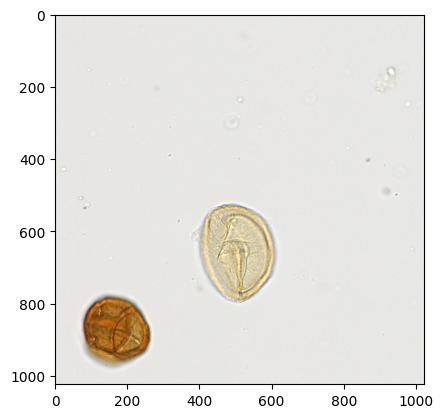

In [ ]:
# Visualize the image (stack)
slice_path=[]
current_image_path= os.path.join(path_to_image, current_example[0][0], current_example[1][0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
img = mpimg.imread(slice_path[4]).copy()      # index can range from (0,8) - the number of z-planes. 

# plt.figure(figsize=(8,8)) # figsize -- inch-by-inch
plt.imshow(img)

In [ ]:
# current_distTransform_path=os.path.join(path_to_image, current_example[0][0], current_example[0][0] + '_masks2', current_example[1][0],current_example[2][0])

# for file in sorted(os.listdir(current_distTransform_path)):
#   if file.endswith('.png'):
#     mask = Image.open(os.path.join(current_distTransform_path, file))
#     mask=np.expand_dims(mask, axis=2)
#     mask = mask.astype(np.float32)

# label = np.copy(mask)         # 11/30/21 added
# label[label > 0] = 1.0          # 11/30/21 added 
# label = label.astype(np.float32)/100.0
# plt.imshow(label)

Text(0.5, 1.0, 'image slice')

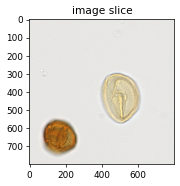

In [ ]:
idx = 2

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1  

i=[0,3,6,9,12,15,18,21,24]
j=[3,6,9,12,15,18,21,24,27]
idx2=3
image_slice = curImg_squeeze[:, int(i[idx2]):int(j[idx2]),: ,:]

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image_slice[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
# plt.imshow((tmpImg.astype(np.uint8)))
#plt.axis('off')
plt.title('image slice')

In [ ]:
softmax = predSeg
print(softmax.shape)

torch.Size([4, 1, 800, 800])


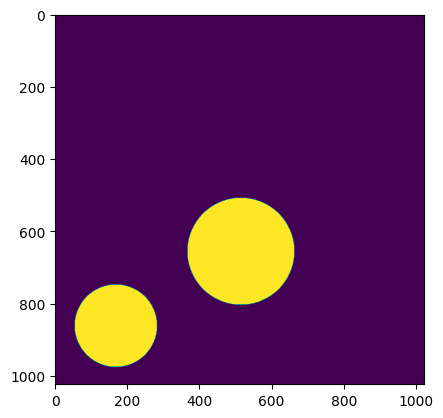

In [ ]:
# Visualize the ground-truth mask
curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
curmask_OrgSize_binary = curmask_OrgSize >0
plt.imshow(curmask_OrgSize_binary)

In [ ]:
# Create lists of (800x800) prediction distance transforms crops and softmax crops.

predDistTransform_crops=[]
softmax_crops = []

for idx in range(0,4):
  tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
  predDistTransform_crops.append(tmpImg)

for idx in range(0,4):
  tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
  # if np.nanmean(tmpImg)>0.99:
  #   tmpImg = np.zeros_like(tmpImg).astype(np.float32)
  softmax_crops.append(tmpImg)


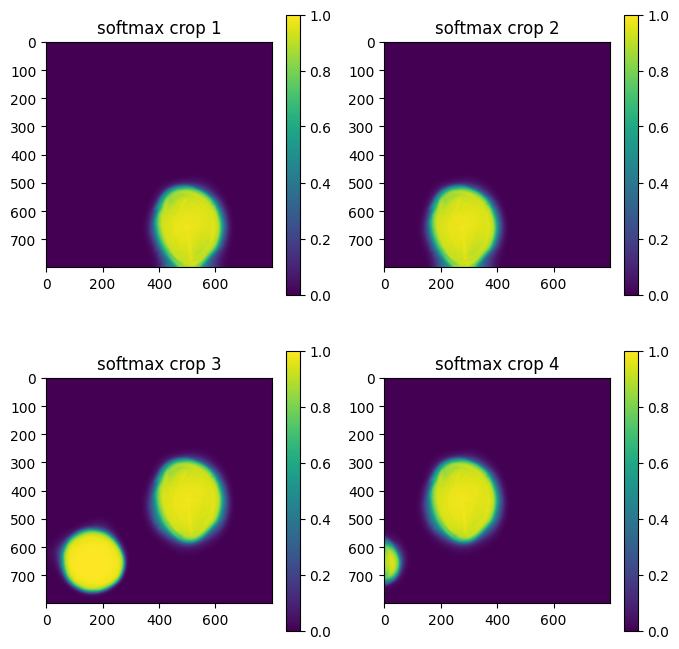

In [ ]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8,8), facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[0]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 1')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[1]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 2')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[2]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 3')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[3]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 4')
plt.colorbar()

In [ ]:
np.mean(softmax_crops[3])

0.09517972

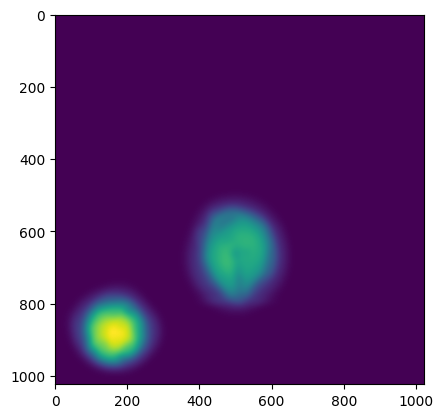

In [ ]:
# create full-sized pred distance transform 

mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
predDistTransform=np.zeros_like(mask_OrgSize)  
predDistTransform=predDistTransform.astype(np.float32)

tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


tmp_predDistTransform_1[0:newSize[0], 0:newSize[0]]=predDistTransform_crops[0]
tmp_predDistTransform_2[0:newSize[0], width-newSize[0]:]=predDistTransform_crops[1]
tmp_predDistTransform_3[height-newSize[0]:, 0:newSize[0]]=predDistTransform_crops[2]
tmp_predDistTransform_4[height-newSize[0]:, width-newSize[0]:]=predDistTransform_crops[3]

predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
# predDistTransform= np.maximum.reduce([tmp_predDistTransform_1])
predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow

plt.imshow(predDistTransform)


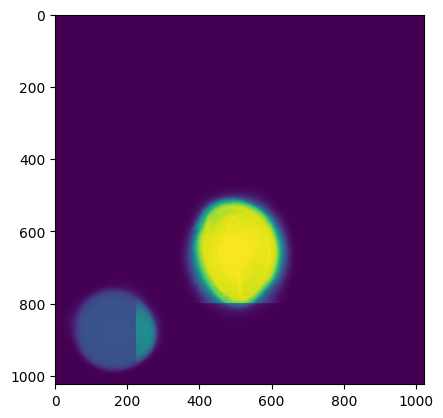

In [ ]:
# create full-sized softmax

height,width = mask_OrgSize.shape
softmax=np.zeros_like(mask_OrgSize)  
softmax=softmax.astype(np.float32)

tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

tmp_softmax_1[0:newSize[0], 0:newSize[0]]=softmax_crops[0]
tmp_softmax_2[0:newSize[0], width-newSize[0]:]=softmax_crops[1]
tmp_softmax_3[height-newSize[0]:, 0:newSize[0]]=softmax_crops[2]
tmp_softmax_4[height-newSize[0]:, width-newSize[0]:]=softmax_crops[3]

softmax = np.mean( np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0 )
# softmax = np.mean( np.array([tmp_softmax_1]), axis = 0)

plt.imshow(softmax)

In [ ]:
# tmp_softmax_1

In [ ]:
pred_distanceTransform = np.copy(predDistTransform)

voting4center = np.copy(pred_distanceTransform)
voting4center[voting4center<0.01] = 0        # Masks out noisy peaks. 

In [ ]:
coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) # Min_distance is the minimum distance between pollen grains in pixels. In dense samples with lots of overlap, this may be decreased to avoid missing detections. In sparser samples, increasing min_distance may reduce false-positives.
print(coord_peaks)

[[881 162]
 [680 473]]


In [ ]:
# Get information from ALL detections in coord_peaks

centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
detection_info = []
detection_info2 = []
# detMask_info = []

size = (400,400)

# i=0

for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    centerMask[y-10:y+10, x-10:x+10] = 1

    left = int(x-(size[0]/2))
    left=max(left,0)
    top = int(y-(size[0]/2))
    top=max(top,0)
    right = int(x+(size[0]/2))
    right=max(right,0)
    bottom = int(y+(size[0]/2))
    bottom=max(bottom,0)

    tmpCrop = softmax[top:bottom, left:right]
    thresh = threshold_otsu(tmpCrop) 
    tmpCrop = tmpCrop> thresh # binarize
    tmpCrop= measure.label(tmpCrop, background=0)
    props = measure.regionprops(tmpCrop) #get the properties of the connected components

    diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
    if len(diameter) !=0 and max(diameter)!=0:
      radius = int(max(diameter)/2)
      predRadiusList += [radius]
      a = len(predRadiusList)-1

      tmpMask = voting4center*0
      tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

      #write bb coords to file
      # bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components

      class_name="det"
      leftBb = x-radius
      leftBb = max(leftBb,0)
      topBb = y-radius
      topBb= max(topBb,0)
      rightBb = x+radius
      rightBb = max(rightBb, 0)
      bottomBb = y+radius
      bottomBb = max(bottomBb,0)

      masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
      confidence = np.nanmean(masked_softmax)
      if confidence > 0.99:
          confidence = 0
      # bbox_info = [class_name,str(confidence) , str(leftBb), str(topBb), str(rightBb), str(bottomBb)]
      bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
      # circle_info = [y,x,radius]

      # detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)
      # bbox_info = ' '.join(bbox_info)
      # detection_info.append(bbox_info)
      detection_info2.append(bbox_info2)
      # detMask_info.append(circle_info)

# print(detection_info)
# print(detection_info2)   # [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

In [ ]:
# Apply Non-Max Suppression to eliminate duplicate detections

NMS_bb = nms(detection_info2,conf_threshold=0.1, iou_threshold=0.3)   # Increasing the confidence threshold will eliminate lower-scoring detections and decreasing will show more low-scoring detections. This threshold can be adjusted as desired. 
NMS_bb = NMS_bb[0]
print(len(NMS_bb))
print(NMS_bb)   # [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

2
[['det', 0.70926785, 328, 535, 618, 825], ['det', 0.25440758, 49, 768, 275, 994]]


In [ ]:
# create detection mask and center mask using the information on each detection in NMS_bb

detMask = voting4center*0
centerMask = voting4center*0
det_info = []

for i in range(len(NMS_bb)):
    confidence = float(NMS_bb[i][1])
    leftBb = int(NMS_bb[i][2])
    topBb = int(NMS_bb[i][3])
    rightBb = int(NMS_bb[i][4])
    bottomBb = int(NMS_bb[i][5])
    diameter = max(rightBb - leftBb, bottomBb - topBb)
    radius = diameter/2
    x = leftBb + radius
    y = topBb +  radius
    det_info.append([y, x, radius])

for i in range(len(det_info)):
  y = int(det_info[i][0])
  x = int(det_info[i][1])
  radius = det_info[i][2]
  detMask = create_circular_mask(detMask, [y, x], radius, value=i+1)
  centerMask[y-10:y+10, x-10:x+10] = 1

In [ ]:
current_image_path= os.path.join(path_to_image, current_example[0][0], current_example[1][0])
slice_path=[]
full_label_names = []
center_radius_list = []

for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
    if file.endswith(".plk"):
      with open(os.path.join(current_image_path,'full_annot.plk'), 'rb') as handle:
          tmpData_list = pickle.load(handle)
          for i in range(len(tmpData_list)):
            shape = tmpData_list[i]
            # for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
            # full_annot.append(shape)
            label_name = shape["label"]
            # if label_name in do_not_include:
            #     continue
            points = shape['points']

            # # export crop masks
            xy = [tuple(point) for point in points]
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            center_radius_list.append((cx,cy,d,label_name))

img_without_label = mpimg.imread(slice_path[5]).copy()
img_with_label = mpimg.imread(slice_path[5]).copy()

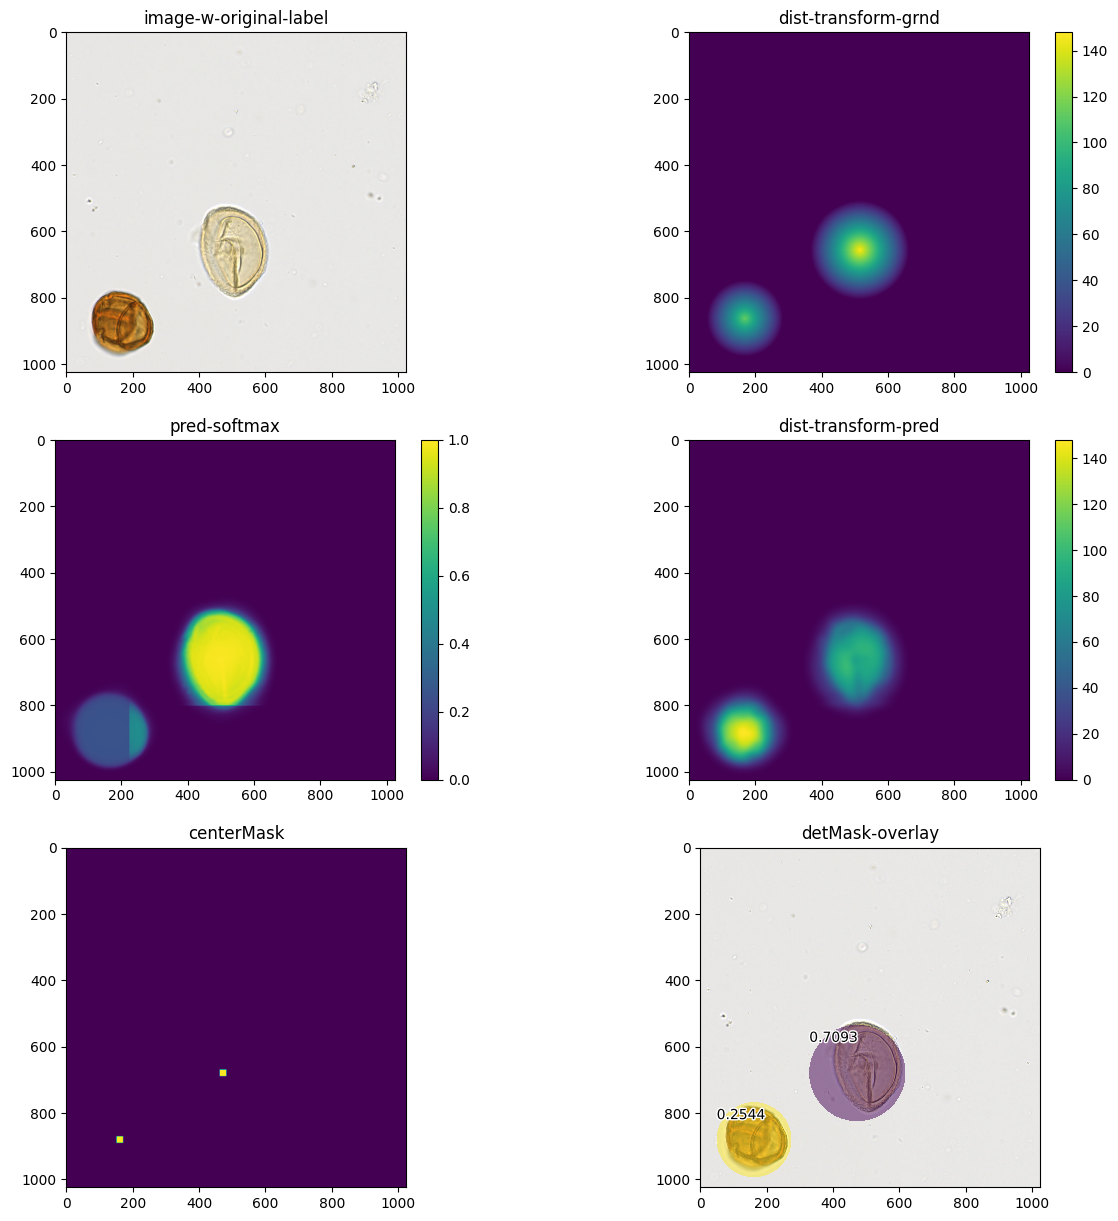

In [ ]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(15,15), facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
slice_path=[]
for idx in range(len(center_radius_list)):
    y = int(center_radius_list[idx][0])
    x = int(center_radius_list[idx][1])
    d = int(center_radius_list[idx][2])
    rr, cc = circle_perimeter(x,y,d, shape=(1040,1392))
    img_with_label[rr, cc] = 0
    plt.text(y-d,x-d, center_radius_list[idx][3],
          fontsize=10,
          color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
plt.imshow(img_with_label)
plt.title('image-w-original-label')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','Image_wTags.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_OrgSize
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','dist-transform-grnd.png'), tmpImg, format='png')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
if np.nanmean(softmax)!=0:
  tmpImg = (softmax-np.min(softmax))/(np.max(softmax)-np.min(softmax))
else:
  tmpImg = softmax
plt.imshow(tmpImg)
plt.title('pred-softmax')
plt.colorbar()
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','pred-softmax.png'), softmax, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = pred_distanceTransform*100
tmpImg = ((tmpImg - tmpImg.min()) * (1/(tmpImg.max() - tmpImg.min()) * np.max(mask_OrgSize)))
plt.imshow(tmpImg)
plt.colorbar()
plt.title('dist-transform-pred')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(centerMask)
plt.title('centerMask')
# plt.colorbar()
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','centerMask.png'), centerMask, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
masked = np.ma.masked_where(detMask == 0, detMask)
plt.imshow(img_without_label, interpolation='none')
plt.imshow(masked, 'viridis', interpolation='none', alpha=0.5)    #'jet' also works as color
plt.title('detMask-overlay')
for idx in range(len(NMS_bb)):
    x = int(NMS_bb[idx][2])
    y = int(NMS_bb[idx][3])
    plt.text(x, y+50,round(NMS_bb[idx][1],4),
             fontsize=10,
             color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','detMask-overlay.png'), masked, format='png')

# Create text files with bounding box info for evaluation

In [ ]:
# models = ['finetuned', 'scratch']
# model = models[]

detections_dir = os.path.join(eval_dir, 'det')  
if not os.path.exists(detections_dir): 
    os.makedirs(detections_dir)
gt_dir = os.path.join(eval_dir, 'gt')           
if not os.path.exists(gt_dir): 
    os.makedirs(gt_dir)

In [ ]:
iterCount, sampleCount = 0, 0
phase = 'test' # 'train'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    #######################################################
    ##       ground-truth: labelOrgSize, mask_peaksOrgSize
    #######################################################
    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    GTSegMask = curmask_OrgSize >0
    GTSegMask = measure.label(GTSegMask, background=0)

    props = measure.regionprops(np.squeeze(GTSegMask)) #get the properties of the connected components
    bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components
    gt_filename = os.path.join(gt_dir, current_example[0][0] + '_' + current_example[1][0] + '_' + current_example[2][0] + '.txt')
    # if os.path.exists(gt_filename):
    #   continue
    # i=2
    gt_info = []
    for i in range(len(props)): 
      class_name="det"
      left = bbox[i][1]
      top = bbox[i][0]
      right = bbox[i][3]
      bottom = bbox[i][2]
      # predDistTransformCrop = predDistTransform[top:bottom, left:right]
      # confidence = np.amax(predDistTransformCrop)
      bbox_info = [class_name, str(left), str(top), str(right), str(bottom)]
      bbox_info = ' '.join(bbox_info)

      gt_info.append(bbox_info)

    fn = open(gt_filename,'w')
    for i in gt_info:
      fn.write(i + "\n")
    fn.close()

    ##############################################
    ##          prediction: 
    ##############################################
    # create a list of (800x800) prediction distance transforms crops and softmax crops

    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
    tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
    tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
    tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

    softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.0001] = 0               
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # create detection mask using peaks and predicted radius
    detMask = voting4center*0
    predRadiusList = []
    size = (400,400)
    detection_info = []
    detection_info2 = []
    det_filename = os.path.join(detections_dir, current_example[0][0] + '_' + current_example[1][0] + '_' + current_example[2][0]+ '.txt')


    for i in range(coord_peaks.shape[0]):
        y, x = coord_peaks[i]

        # crop a 400x400 box around predicted peak
        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        # predict the radius by segmenting and measuring the largest object in the crop
        tmpCrop = predDistTransform[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        radius = int(max(diameter)/2)
        predRadiusList += [radius]
        
        # create detection mask

        tmpMask = voting4center*0
        tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[i], value=1)
        masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 

        class_name="det"
        leftBb = x-radius
        leftBb = max(leftBb,0)
        topBb = y-radius
        topBb= max(topBb,0)
        rightBb = x+radius
        rightBb = max(rightBb, 0)
        bottomBb = y+radius
        bottomBb = max(bottomBb,0)

        confidence = np.nanmean(masked_softmax)
        if confidence > 0.99:
          confidence = 0

        bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
        detection_info2.append(bbox_info2)

    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=0, iou_threshold=0.3)    # When exporting detections for evaluation, we use no confidence threshold because we want as many detections as possible (even very low-scoring detections) to draw a precision-recall curve. 
    NMS_bb = NMS_bb[1]


    fn = open(det_filename,'w')
    # for i in detection_info:
    for i in NMS_bb:
      fn.write(i + "\n")
    fn.close()


50/180
100/180
150/180
